# ChromProcess Introduction Part 2

This notebook gives an example workflow for analysing a peaks from a series of chromatograms.

In [1]:
import tomli
import numpy as np
import pandas as pd
from pathlib import Path
from ChromProcess import Utils
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # Prevents Pandas future warning

In [2]:
data_file = Path("example_data/Example/ExperimentalData/ExamplePeakCollections/series_peak_table.csv")
peak_series = pd.read_csv(data_file)
peak_series.head()

,filename,retention_time,integral,height,start,end,is_retention_time,is_integral,deconvoluted,time
0,chrom_001.csv,7.813500,7375.790668,315311.188750,7.773625,7.888292,6.720083,2919.621001,False,10.0
1,chrom_001.csv,7.999625,1775.619826,93307.027408,7.974708,8.047833,6.720083,2919.621001,False,10.0
2,chrom_001.csv,8.096000,2056.209856,105636.424117,8.062792,8.260500,6.720083,2919.621001,False,10.0
3,chrom_001.csv,10.395833,2438.641184,85395.679287,10.349292,10.447333,6.720083,2919.621001,False,10.0
4,chrom_001.csv,10.681625,8939.897195,232477.071506,10.630125,10.744792,6.720083,2919.621001,False,10.0


First, align and normalise the peak retention times and integrals to the internal standard.

In [3]:
peak_series["aligned_retention_time"] = peak_series.retention_time - peak_series.is_retention_time + peak_series.is_retention_time.mean()
peak_series["normalised_integral"] = peak_series.integral / peak_series.is_integral

Similar peaks across each chromatogram do not have exactly the same retention time. They can be assembled into a series by binning their values. First, a series of boundaries is created using an agglomerative mean-shift algorithm, then each peak retention time is assigned to a boundary.

In [4]:
rt_width = 0.025
rt_bin_borders = Utils.create_bins(peak_series.aligned_retention_time, rt_width)
intervals = pd.IntervalIndex.from_tuples(rt_bin_borders, closed="both")
peak_series["binned_retention_time"] = pd.cut(
    x=peak_series["aligned_retention_time"],
    bins=intervals,
    include_lowest=True,
)

Grouping the data by their binned retention time values then gives series timecourses.

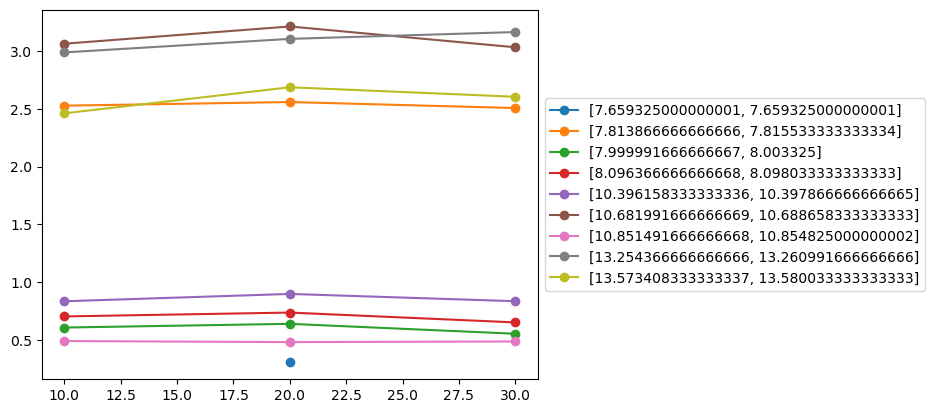

In [5]:
_, ax = plt.subplots()
for rt, series in peak_series.groupby("binned_retention_time"):
    series = series.sort_values("time")
    time = series.time
    integral = series.normalised_integral
    ax.plot(
        time,
        integral,
        "-o",
        label=f"{rt}",
    )
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()